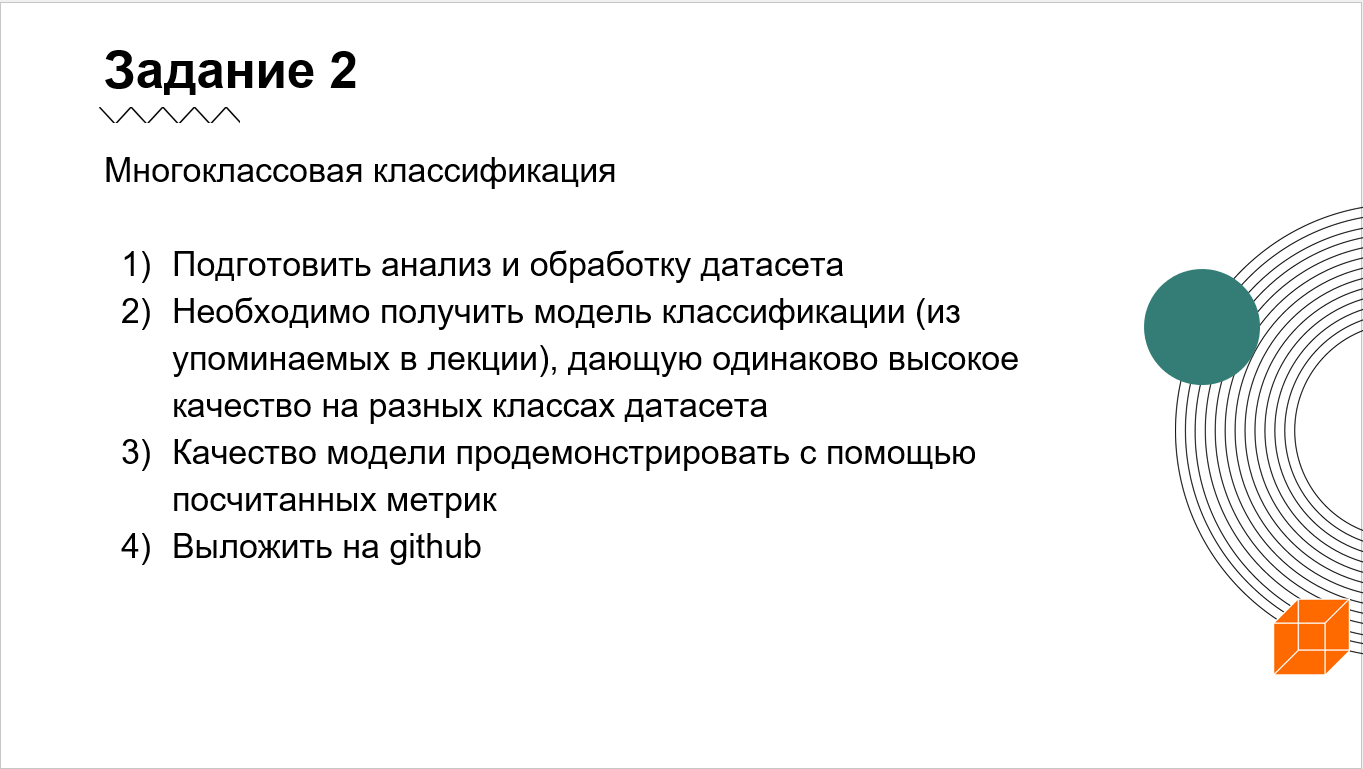

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 106.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
!sudo apt-get install build-essential cmake libboost-all-dev
!pip install https://github.com/kpu/kenlm/archive/master.zip


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
libboost-all-dev is already the newest version (1.74.0.3ubuntu7).
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.6/553.6 kB 9.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for kenlm: filename=kenlm-0.2.0-cp310-cp310-linux_x86_64.whl size=3184348 sha256=d3c6e15a79dcfa46bdce6d4a3451844d7ff0ba2fdd707d94b2cc6905bbb4d0ff
  Stored in directory: /tmp/pip-ephem-wheel-cache-ocgi_259/wheels/a5/73/ee/670fbd0cee8f6f0b21d10987cb042291e662e26e1a07026462
Successfully built kenlm


In [5]:
import pandas as pd
import re

#1. Анализ и обработка датасета

In [6]:
from google.colab import files

uploaded = files.upload()

Saving dataset.xlsx to dataset.xlsx


In [7]:
df = pd.read_excel('dataset.xlsx')
df.head()

,oid,text,category
0,749208109,СПОЧНО СООБЩЕСТВО ПРОДАЕТСЯ ЗА 1300Р ЗА ПОКУПК...,esport
1,749208109,Пусть это побудет здесь БорьбаВпрямомЭфире How...,esport
2,749208109,Раздача пиздюлей от Мунсунга. HowToFtokenoid Б...,esport
3,749208109,Не знаю как вам но мне стилистика нравится пус...,esport
4,749208109,Скриншоты из новой главы. Тэхунчика показали и...,esport


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53198 entries, 0 to 53197
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   oid       53198 non-null  int64 
 1   text      53198 non-null  object
 2   category  53198 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [9]:
df.category.unique() #категории, которые у нас есть в датасете

array(['esport', 'martial_arts', 'tennis', 'basketball', 'volleyball',
       'boardgames', 'athletics', 'winter_sport', 'football', 'motosport',
       'autosport', 'extreme', 'hockey'], dtype=object)

In [10]:
category_count = len(df.category.unique())
category_count

13

Преобразуем категории в числовые данные

In [11]:
df['category_code'] = pd.Categorical(df['category']).codes

df

,oid,text,category,category_code
0,749208109,СПОЧНО СООБЩЕСТВО ПРОДАЕТСЯ ЗА 1300Р ЗА ПОКУПК...,esport,4
1,749208109,Пусть это побудет здесь БорьбаВпрямомЭфире How...,esport,4
2,749208109,Раздача пиздюлей от Мунсунга. HowToFtokenoid Б...,esport,4
3,749208109,Не знаю как вам но мне стилистика нравится пус...,esport,4
4,749208109,Скриншоты из новой главы. Тэхунчика показали и...,esport,4
...,...,...,...,...
53193,910636962,8 битная буря снова накрыла пикселями автомоби...,autosport,1
53194,669736851,Ира Сидоркова объясняет как сказалась на ее ма...,autosport,1
53195,558919241,24 я ракетка мира хорват Марин Чилич обыграл и...,tennis,10
53196,776944963,Стал известен календарь мужской сборной России...,volleyball,11


In [12]:
 cnt = df['category_code'].value_counts()
 cnt

category_code
0     4782
11    4683
10    4584
3     4551
12    4536
9     4528
4     4509
2     4329
6     4262
8     4259
5     3172
1     3152
7     1851
Name: count, dtype: int64

можем заметить, что все классы, кроме 5, 1, 7, +- сбалансированны

Токенизация и исправление орфографических ошибок в тексте

In [13]:
# убираем знаки препинания и делаем текст маленькими буквами
df['text'] = df['text'].replace(r'[^\w\s]',' ',regex=True).replace(r'\s+',' ',regex=True).str.lower()
df

,oid,text,category,category_code
0,749208109,спочно сообщество продается за 1300р за покупк...,esport,4
1,749208109,пусть это побудет здесь борьбавпрямомэфире how...,esport,4
2,749208109,раздача пиздюлей от мунсунга howtoftokenoid бо...,esport,4
3,749208109,не знаю как вам но мне стилистика нравится пус...,esport,4
4,749208109,скриншоты из новой главы тэхунчика показали и ...,esport,4
...,...,...,...,...
53193,910636962,8 битная буря снова накрыла пикселями автомоби...,autosport,1
53194,669736851,ира сидоркова объясняет как сказалась на ее ма...,autosport,1
53195,558919241,24 я ракетка мира хорват марин чилич обыграл и...,tennis,10
53196,776944963,стал известен календарь мужской сборной россии...,volleyball,11


In [14]:
# удаляем цифры из строк
def remove_digits(text):
    return re.sub(r'\d+', '', text)


df["cleaned_data"] = df["text"].apply(remove_digits)
df

,oid,text,category,category_code,cleaned_data
0,749208109,спочно сообщество продается за 1300р за покупк...,esport,4,спочно сообщество продается за р за покупкой п...
1,749208109,пусть это побудет здесь борьбавпрямомэфире how...,esport,4,пусть это побудет здесь борьбавпрямомэфире how...
2,749208109,раздача пиздюлей от мунсунга howtoftokenoid бо...,esport,4,раздача пиздюлей от мунсунга howtoftokenoid бо...
3,749208109,не знаю как вам но мне стилистика нравится пус...,esport,4,не знаю как вам но мне стилистика нравится пус...
4,749208109,скриншоты из новой главы тэхунчика показали и ...,esport,4,скриншоты из новой главы тэхунчика показали и ...
...,...,...,...,...,...
53193,910636962,8 битная буря снова накрыла пикселями автомоби...,autosport,1,битная буря снова накрыла пикселями автомобил...
53194,669736851,ира сидоркова объясняет как сказалась на ее ма...,autosport,1,ира сидоркова объясняет как сказалась на ее ма...
53195,558919241,24 я ракетка мира хорват марин чилич обыграл и...,tennis,10,я ракетка мира хорват марин чилич обыграл исп...
53196,776944963,стал известен календарь мужской сборной россии...,volleyball,11,стал известен календарь мужской сборной россии...


In [15]:
df = df.reindex(columns=['oid', 'cleaned_data', 'category', 'category_code'])
df = df.rename(columns={'cleaned_data': 'text'})
df

,oid,text,category,category_code
0,749208109,спочно сообщество продается за р за покупкой п...,esport,4
1,749208109,пусть это побудет здесь борьбавпрямомэфире how...,esport,4
2,749208109,раздача пиздюлей от мунсунга howtoftokenoid бо...,esport,4
3,749208109,не знаю как вам но мне стилистика нравится пус...,esport,4
4,749208109,скриншоты из новой главы тэхунчика показали и ...,esport,4
...,...,...,...,...
53193,910636962,битная буря снова накрыла пикселями автомобил...,autosport,1
53194,669736851,ира сидоркова объясняет как сказалась на ее ма...,autosport,1
53195,558919241,я ракетка мира хорват марин чилич обыграл исп...,tennis,10
53196,776944963,стал известен календарь мужской сборной россии...,volleyball,11


In [16]:
from nltk.corpus import stopwords
stopwords_rus = stopwords.words("russian")

In [17]:
df['text_without_stopwords'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_rus)]))
df # можно посмотреть разницу в данных

,oid,text,category,category_code,text_without_stopwords
0,749208109,спочно сообщество продается за р за покупкой п...,esport,4,спочно сообщество продается р покупкой пишите ...
1,749208109,пусть это побудет здесь борьбавпрямомэфире how...,esport,4,пусть это побудет борьбавпрямомэфире howtohtok...
2,749208109,раздача пиздюлей от мунсунга howtoftokenoid бо...,esport,4,раздача пиздюлей мунсунга howtoftokenoid борьб...
3,749208109,не знаю как вам но мне стилистика нравится пус...,esport,4,знаю стилистика нравится пускай странная howto...
4,749208109,скриншоты из новой главы тэхунчика показали и ...,esport,4,скриншоты новой главы тэхунчика показали хобина
...,...,...,...,...,...
53193,910636962,битная буря снова накрыла пикселями автомобил...,autosport,1,битная буря снова накрыла пикселями автомобиль...
53194,669736851,ира сидоркова объясняет как сказалась на ее ма...,autosport,1,ира сидоркова объясняет сказалась машине резул...
53195,558919241,я ракетка мира хорват марин чилич обыграл исп...,tennis,10,ракетка мира хорват марин чилич обыграл испанц...
53196,776944963,стал известен календарь мужской сборной россии...,volleyball,11,стал известен календарь мужской сборной россии...


In [18]:
df = df.reindex(columns=['oid', 'text_without_stopwords', 'category', 'category_code'])
df = df.rename(columns={'text_without_stopwords': 'text'})
df

,oid,text,category,category_code
0,749208109,спочно сообщество продается р покупкой пишите ...,esport,4
1,749208109,пусть это побудет борьбавпрямомэфире howtohtok...,esport,4
2,749208109,раздача пиздюлей мунсунга howtoftokenoid борьб...,esport,4
3,749208109,знаю стилистика нравится пускай странная howto...,esport,4
4,749208109,скриншоты новой главы тэхунчика показали хобина,esport,4
...,...,...,...,...
53193,910636962,битная буря снова накрыла пикселями автомобиль...,autosport,1
53194,669736851,ира сидоркова объясняет сказалась машине резул...,autosport,1
53195,558919241,ракетка мира хорват марин чилич обыграл испанц...,tennis,10
53196,776944963,стал известен календарь мужской сборной россии...,volleyball,11


In [19]:
def remove_english_words(text): #уберем все английские слова, чтобы было проще делать лемматизацию
    return re.sub(r'\b[a-zA-Z]+\b', '', text).strip()

df['text_without_english'] = df['text'].apply(remove_english_words)
df


,oid,text,category,category_code,text_without_english
0,749208109,спочно сообщество продается р покупкой пишите ...,esport,4,спочно сообщество продается р покупкой пишите ...
1,749208109,пусть это побудет борьбавпрямомэфире howtohtok...,esport,4,пусть это побудет борьбавпрямомэфире
2,749208109,раздача пиздюлей мунсунга howtoftokenoid борьб...,esport,4,раздача пиздюлей мунсунга борьбавпрямомэфире
3,749208109,знаю стилистика нравится пускай странная howto...,esport,4,знаю стилистика нравится пускай странная борь...
4,749208109,скриншоты новой главы тэхунчика показали хобина,esport,4,скриншоты новой главы тэхунчика показали хобина
...,...,...,...,...,...
53193,910636962,битная буря снова накрыла пикселями автомобиль...,autosport,1,битная буря снова накрыла пикселями автомобиль...
53194,669736851,ира сидоркова объясняет сказалась машине резул...,autosport,1,ира сидоркова объясняет сказалась машине резул...
53195,558919241,ракетка мира хорват марин чилич обыграл испанц...,tennis,10,ракетка мира хорват марин чилич обыграл испанц...
53196,776944963,стал известен календарь мужской сборной россии...,volleyball,11,стал известен календарь мужской сборной россии...


In [20]:
df = df.reindex(columns=['oid', 'text_without_english', 'category', 'category_code'])
df = df.rename(columns={'text_without_english': 'text'})
df

,oid,text,category,category_code
0,749208109,спочно сообщество продается р покупкой пишите ...,esport,4
1,749208109,пусть это побудет борьбавпрямомэфире,esport,4
2,749208109,раздача пиздюлей мунсунга борьбавпрямомэфире,esport,4
3,749208109,знаю стилистика нравится пускай странная борь...,esport,4
4,749208109,скриншоты новой главы тэхунчика показали хобина,esport,4
...,...,...,...,...
53193,910636962,битная буря снова накрыла пикселями автомобиль...,autosport,1
53194,669736851,ира сидоркова объясняет сказалась машине резул...,autosport,1
53195,558919241,ракетка мира хорват марин чилич обыграл испанц...,tennis,10
53196,776944963,стал известен календарь мужской сборной россии...,volleyball,11


In [21]:
df.dropna(inplace=True)
df.drop_duplicates(subset="text",inplace=True)
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)
df

,oid,text,category,category_code
0,749208109,спочно сообщество продается р покупкой пишите ...,esport,4
1,749208109,пусть это побудет борьбавпрямомэфире,esport,4
2,749208109,раздача пиздюлей мунсунга борьбавпрямомэфире,esport,4
3,749208109,знаю стилистика нравится пускай странная борь...,esport,4
4,749208109,скриншоты новой главы тэхунчика показали хобина,esport,4
...,...,...,...,...
47535,910636962,битная буря снова накрыла пикселями автомобиль...,autosport,1
47536,669736851,ира сидоркова объясняет сказалась машине резул...,autosport,1
47537,558919241,ракетка мира хорват марин чилич обыграл испанц...,tennis,10
47538,776944963,стал известен календарь мужской сборной россии...,volleyball,11


In [22]:
 cnt = df['category_code'].value_counts()
 cnt

category_code
10    4424
12    4378
11    4262
6     4156
8     4003
0     3929
4     3886
9     3766
2     3655
3     3521
1     2999
5     2747
7     1814
Name: count, dtype: int64

In [23]:
df.to_csv("dataset_new.csv") #скачивал на всякий пожарный

# Лемматизация

In [24]:
import pandas as pd
import spacy
from tqdm import tqdm

In [25]:
nlp = spacy.load("ru_core_news_sm")

def lemmatize(text):
    doc = nlp(text)
    lemmatized_words = [token.lemma_ for token in doc]
    return ' '.join(lemmatized_words)

tqdm.pandas()  # Для отображения прогресса
df['lemmatized_text'] = df['text'].progress_apply(lemmatize)
df

100%|██████████| 47540/47540 [18:51<00:00, 42.01it/s]


,oid,text,category,category_code,lemmatized_text
0,749208109,спочно сообщество продается р покупкой пишите ...,esport,4,спочно сообщество продаваться р покупкой пишит...
1,749208109,пусть это побудет борьбавпрямомэфире,esport,4,пусть это побыть борьбавпрямомэфире
2,749208109,раздача пиздюлей мунсунга борьбавпрямомэфире,esport,4,раздача пиздюлей мунсунга борьбавпрямомэфире
3,749208109,знаю стилистика нравится пускай странная борь...,esport,4,знать стилистика нравиться пускай странный б...
4,749208109,скриншоты новой главы тэхунчика показали хобина,esport,4,скриншот новый глава тэхунчика показать хобина
...,...,...,...,...,...
47535,910636962,битная буря снова накрыла пикселями автомобиль...,autosport,1,битный буря снова накрыть пикселями автомобиль...
47536,669736851,ира сидоркова объясняет сказалась машине резул...,autosport,1,ира сидоркова объяснять сказаться машина резул...
47537,558919241,ракетка мира хорват марин чилич обыграл испанц...,tennis,10,ракетка мир хорват марин чилич обыграть испане...
47538,776944963,стал известен календарь мужской сборной россии...,volleyball,11,стать известный календарь мужской сборная росс...


In [26]:
df.to_csv("dataset_new_lemm.csv")


#Обучение и тестирование моделей

###Импортируем все необходимое для моделей

In [56]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, f1_score

###Делим выборку на трейн и тест и векторизируем данные

In [57]:
X_train, X_test, y_train, y_test = train_test_split(df['lemmatized_text'], df['category_code'], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

####Логистическая регрессия

In [58]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [59]:
y_pred = model.predict(X_test_tfidf)

In [72]:
themes = ['athletics', 'autosport', 'basketball', 'boardgames', 'esport', 'extreme', 'football', 'hockey', 'martial_arts', 'motosport', 'tennis', 'volleyball', 'winter_sport'] # Example list, replace with your actual theme names

y_pred_proba = model.predict_proba(X_test_tfidf)

print(classification_report(y_test, y_pred, target_names=themes))
print("Accuracy:", accuracy_score(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba, multi_class='ovr')}")

              precision    recall  f1-score   support

   athletics       0.88      0.84      0.86       767
   autosport       0.89      0.78      0.83       611
  basketball       0.90      0.82      0.86       741
  boardgames       0.88      0.94      0.91       711
      esport       0.65      0.80      0.72       765
     extreme       0.66      0.69      0.67       554
    football       0.79      0.83      0.81       828
      hockey       0.94      0.69      0.80       382
martial_arts       0.77      0.84      0.80       764
   motosport       0.84      0.84      0.84       769
      tennis       0.96      0.93      0.95       856
  volleyball       0.90      0.83      0.86       894
winter_sport       0.86      0.87      0.87       866

    accuracy                           0.83      9508
   macro avg       0.84      0.82      0.83      9508
weighted avg       0.84      0.83      0.84      9508

Accuracy: 0.8339293226756416
ROC-AUC: 0.9790641520537826


####Random forest

In [64]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

In [65]:
y_pred_rf = model_rf.predict(X_test_tfidf)

In [71]:
themes = ['athletics', 'autosport', 'basketball', 'boardgames', 'esport', 'extreme', 'football', 'hockey', 'martial_arts', 'motosport', 'tennis', 'volleyball', 'winter_sport'] # Example list, replace with your actual theme names

y_pred_proba_rf = model_rf.predict_proba(X_test_tfidf)

print(classification_report(y_test, y_pred_rf, target_names=themes))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_rf, multi_class='ovr')}")

              precision    recall  f1-score   support

   athletics       0.85      0.84      0.85       767
   autosport       0.82      0.78      0.80       611
  basketball       0.85      0.77      0.81       741
  boardgames       0.87      0.88      0.87       711
      esport       0.49      0.78      0.60       765
     extreme       0.70      0.58      0.63       554
    football       0.72      0.79      0.75       828
      hockey       0.93      0.59      0.73       382
martial_arts       0.80      0.79      0.80       764
   motosport       0.85      0.79      0.82       769
      tennis       0.92      0.93      0.92       856
  volleyball       0.93      0.79      0.85       894
winter_sport       0.84      0.82      0.83       866

    accuracy                           0.79      9508
   macro avg       0.81      0.78      0.79      9508
weighted avg       0.81      0.79      0.80      9508

Accuracy: 0.7934371055952881
ROC-AUC: 0.965476030037413


####Наивный Байес

In [67]:
model_nb = MultinomialNB()
model_nb.fit(X_train_tfidf, y_train)

MultinomialNB()

In [68]:
y_pred_nb = model_nb.predict(X_test_tfidf)

In [70]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

themes = ['athletics', 'autosport', 'basketball', 'boardgames', 'esport', 'extreme', 'football', 'hockey', 'martial_arts', 'motosport', 'tennis', 'volleyball', 'winter_sport'] # Example list, replace with your actual theme names

y_pred_proba_nb = model_nb.predict_proba(X_test_tfidf)

print(classification_report(y_test, y_pred_nb, target_names=themes))
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_nb, multi_class='ovr')}")

              precision    recall  f1-score   support

   athletics       0.73      0.89      0.80       767
   autosport       0.98      0.71      0.82       611
  basketball       0.91      0.81      0.86       741
  boardgames       0.77      0.94      0.85       711
      esport       0.76      0.65      0.70       765
     extreme       0.90      0.40      0.56       554
    football       0.80      0.79      0.79       828
      hockey       0.98      0.37      0.53       382
martial_arts       0.84      0.79      0.82       764
   motosport       0.82      0.86      0.84       769
      tennis       0.87      0.96      0.91       856
  volleyball       0.73      0.87      0.79       894
winter_sport       0.67      0.93      0.78       866

    accuracy                           0.80      9508
   macro avg       0.83      0.77      0.77      9508
weighted avg       0.81      0.80      0.79      9508

Accuracy: 0.7954354228018511
ROC-AUC: 0.9759140170827169


#Вывод
По метрикам лучшая из моделей, которую я успел протестировать- лог регрессия.

Хотелось бы еще посмотреть как 3 основных вида бустинга(XGBoost, LightGBM и CatBoost) справляются с этим, но это я уже сделаю сам после дедлайна для себя.